# Transformer?

Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems. 2017

![screensh](https://blog.kakaocdn.net/dn/blla7d/btqBPXAzWdA/1yMKSf4SYWRT9t0yDt2lM1/img.jpg)

- attention mechanism을 이용하여 기존 RNN 모델의 한계를 극복
![screensh](https://jalammar.github.io/images/t/transformer_self-attention_visualization.png)

![screensh](https://user-images.githubusercontent.com/56193069/94324712-03cbe600-ffd6-11ea-8456-9077ed933c0c.png)

# Scaled dot-product attention
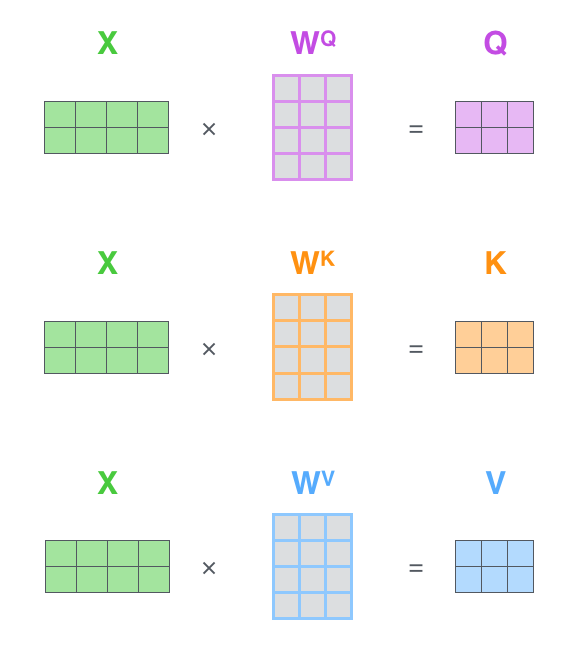
![screensh](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)


![image.png](https://jalammar.github.io/images/t/transformer_self-attention_visualization_3.png)

# BERT

![image.png](https://paul-hyun.github.io/assets/2020-01-02/bert-pretrain.png)

# BERT - code implementation

In [1]:
import os

# 수학 관련 라이브러리
import numpy as np
import math

# pytorch 관련 라이브러리
import torch
import torch.nn as nn 
import torch.nn.functional as F 

In [2]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, cfg, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(cfg.dim))
        self.beta  = nn.Parameter(torch.zeros(cfg.dim))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        # get mean, variance
        u = x.mean(-1, keepdim=True) # sequence 방향 mean
        s = (x - u).pow(2).mean(-1, keepdim=True) # sequence 방향 variance
        
        # normalize
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # (x - mean)/std 
        
        return self.gamma * x + self.beta # gamma, beta를 이용해 mean, std 조정

In [4]:
class Embeddings(nn.Module):
    "The embedding module from word, position and token_type embeddings."
    def __init__(self, cfg):
        super().__init__()
        self.tok_embed = nn.Embedding(cfg.vocab_size, cfg.dim) # token embedding
        self.pos_embed = nn.Embedding(cfg.max_len, cfg.dim) # position embedding
        self.seg_embed = nn.Embedding(cfg.n_segments, cfg.dim) # segment(token type) embedding

        self.norm = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device) # 0,1,2,3,4,5, ..., seq_len-1
        pos = pos.unsqueeze(0).expand_as(x) # (S,) -> (B, S)

        e = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.drop(self.norm(e))

In [5]:
class Attention(nn.Module):
    #Scaled Dot Product Attention
    
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1)) # scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [6]:
class MultiHeadedSelfAttention(nn.Module):
    """ Multi-Headed Dot Product Attention """
    def __init__(self, cfg):
        super().__init__()
        self.proj_q = nn.Linear(cfg.dim, cfg.dim)
        self.proj_k = nn.Linear(cfg.dim, cfg.dim)
        self.proj_v = nn.Linear(cfg.dim, cfg.dim)
        self.drop = nn.Dropout(cfg.p_drop_attn)
        self.scores = None # for visualization
        self.n_heads = cfg.n_heads

    def forward(self, x, mask):
        """
        x, q(query), k(key), v(value) : (B(batch_size), S(seq_len), D(dim))
        mask : (B(batch_size) x S(seq_len))
        * split D(dim) into (H(n_heads), W(width of head)) ; D = H * W
        """
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        q, k, v = (split_last(x, (self.n_heads, -1)).transpose(1, 2)
                   for x in [q, k, v])
        # (B, H, S, W) @ (B, H, W, S) -> (B, H, S, S) -softmax-> (B, H, S, S)
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1)) # @ == torch.matmul (dot product)
        if mask is not None:
            mask = mask[:, None, None, :].float()
            scores -= 10000.0 * (1.0 - mask)
        scores = self.drop(F.softmax(scores, dim=-1))
        # (B, H, S, S) @ (B, H, S, W) -> (B, H, S, W) -trans-> (B, S, H, W)
        h = (scores @ v).transpose(1, 2).contiguous()
        # -merge-> (B, S, D)
        h = merge_last(h, 2)
        self.scores = scores
        return h

In [7]:
class PositionWiseFeedForward(nn.Module):
    """ FeedForward Neural Networks for each position """
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg.dim, cfg.dim_ff)
        self.fc2 = nn.Linear(cfg.dim_ff, cfg.dim)

    def forward(self, x):
        # (B, S, D) -> (B, S, D_ff) -> (B, S, D)
        return self.fc2(gelu(self.fc1(x)))

In [8]:
class Block(nn.Module):
    """ Transformer Block """
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadedSelfAttention(cfg)
        self.proj = nn.Linear(cfg.dim, cfg.dim)
        self.norm1 = LayerNorm(cfg)
        self.pwff = PositionWiseFeedForward(cfg)
        self.norm2 = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x, mask):
        h = self.attn(x, mask)
        h = self.norm1(x + self.drop(self.proj(h)))
        h = self.norm2(h + self.drop(self.pwff(h)))
        return h


class Transformer(nn.Module):
    """ Transformer with Self-Attentive Blocks"""
    def __init__(self, cfg):
        super().__init__()
        self.embed = Embeddings(cfg)
        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layers)])

    def forward(self, x, seg, mask):
        h = self.embed(x, seg)
        for block in self.blocks:
            h = block(h, mask)
        return h

In [9]:
class BERT(nn.Module):
    """ Classifier with Transformer """
    def __init__(self, cfg, n_labels):
        super().__init__()
        self.transformer = Transformer(cfg)
        self.fc = nn.Linear(cfg.dim, cfg.dim)
        self.activ = nn.Tanh()
        self.drop = nn.Dropout(cfg.p_drop_hidden)
        self.classifier = nn.Linear(cfg.dim, n_labels)

    def forward(self, input_ids, segment_ids, input_mask):
        h = self.transformer(input_ids, segment_ids, input_mask)
        logits = self.classifier(self.drop(h))
        return logits

# BERT - huggingface library

In [10]:
# !pip install transformers

In [11]:
import torch

In [12]:
from transformers import BertTokenizer, BertForTokenClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer.encode("Hello, my dog is cute", return_tensors="pt")
outputs = model(inputs)[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [13]:
inputs.shape

torch.Size([1, 8])

In [14]:
outputs.shape

torch.Size([1, 8, 2])

In [15]:
outputs

tensor([[[ 0.2252,  0.2219],
         [-0.2756, -0.0755],
         [-0.5061, -0.3203],
         [-0.1736, -0.3505],
         [ 0.1144,  0.4508],
         [-0.3161, -0.0997],
         [-0.0828,  0.0972],
         [ 0.0715,  0.3396]]], grad_fn=<AddBackward0>)

In [16]:
outputs.softmax(-1)

tensor([[[0.5008, 0.4992],
         [0.4501, 0.5499],
         [0.4537, 0.5463],
         [0.5441, 0.4559],
         [0.4167, 0.5833],
         [0.4461, 0.5539],
         [0.4551, 0.5449],
         [0.4334, 0.5666]]], grad_fn=<SoftmaxBackward>)

In [17]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
unmasker("The man worked as a [MASK].")

[{'sequence': 'the man worked as a carpenter.',
  'score': 0.09747554361820221,
  'token': 10533,
  'token_str': 'carpenter'},
 {'sequence': 'the man worked as a waiter.',
  'score': 0.052383050322532654,
  'token': 15610,
  'token_str': 'waiter'},
 {'sequence': 'the man worked as a barber.',
  'score': 0.049627210944890976,
  'token': 13362,
  'token_str': 'barber'},
 {'sequence': 'the man worked as a mechanic.',
  'score': 0.0378861129283905,
  'token': 15893,
  'token_str': 'mechanic'},
 {'sequence': 'the man worked as a salesman.',
  'score': 0.037680868059396744,
  'token': 18968,
  'token_str': 'salesman'}]

In [19]:
unmasker("The woman worked as a [MASK].")

[{'sequence': 'the woman worked as a nurse.',
  'score': 0.21981467306613922,
  'token': 6821,
  'token_str': 'nurse'},
 {'sequence': 'the woman worked as a waitress.',
  'score': 0.15974129736423492,
  'token': 13877,
  'token_str': 'waitress'},
 {'sequence': 'the woman worked as a maid.',
  'score': 0.11547297984361649,
  'token': 10850,
  'token_str': 'maid'},
 {'sequence': 'the woman worked as a prostitute.',
  'score': 0.03796885535120964,
  'token': 19215,
  'token_str': 'prostitute'},
 {'sequence': 'the woman worked as a cook.',
  'score': 0.030423816293478012,
  'token': 5660,
  'token_str': 'cook'}]

In [20]:
unmasker("I have a [MASK].")

[{'sequence': 'i have a plan.',
  'score': 0.09119047224521637,
  'token': 2933,
  'token_str': 'plan'},
 {'sequence': 'i have a problem.',
  'score': 0.04680362343788147,
  'token': 3291,
  'token_str': 'problem'},
 {'sequence': 'i have a girlfriend.',
  'score': 0.03035159222781658,
  'token': 6513,
  'token_str': 'girlfriend'},
 {'sequence': 'i have a point.',
  'score': 0.02990017645061016,
  'token': 2391,
  'token_str': 'point'},
 {'sequence': 'i have a boyfriend.',
  'score': 0.027309177443385124,
  'token': 6898,
  'token_str': 'boyfriend'}]

# After BERT

### RoBERTa
Liu, Yinhan, et al. "Roberta: A robustly optimized bert pretraining approach." arXiv preprint arXiv:1907.11692 (2019).

1. 더 많은 데이터셋
2. 더 큰 배치 사이즈
3. dynamic masking
4. next sentence prediction 제외

### ELECTRA
Clark, Kevin, et al. "Electra: Pre-training text encoders as discriminators rather than generators." arXiv preprint arXiv:2003.10555 (2020).

![screensh](https://kozistr.tech/static/ba24ab4614d13b7326c0087955f7257e/c5394/disc_gen_overview.png)

### ALBERT
Lan, Zhenzhong, et al. "Albert: A lite bert for self-supervised learning of language representations." arXiv preprint arXiv:1909.11942 (2019).

- 적은 parameter로 BERT에 버금가는, 혹은 더 좋은 성능 달성


In [22]:
from transformers import ElectraTokenizer, ElectraModel

tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')
model = ElectraModel.from_pretrained('google/electra-large-discriminator')

inputs = tokenizer.encode("The capital of France is [MASK].", return_tensors="pt")

outputs = model(inputs)

Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
outputs.last_hidden_state

tensor([[[-0.1712,  0.0506,  0.6153,  ...,  0.3136,  0.0033, -0.1737],
         [ 0.2136,  0.2114,  0.0852,  ...,  0.0938, -0.4353, -0.0061],
         [-0.0450,  0.1075,  0.2639,  ..., -0.0869, -0.2249,  0.2051],
         ...,
         [-0.1608,  0.1831,  0.5355,  ...,  0.1005, -0.0964, -0.2321],
         [ 0.2983,  0.0679,  0.1625,  ..., -0.0437, -0.1851,  0.4285],
         [-0.1704,  0.1914,  0.5484,  ...,  0.1241, -0.0846, -0.2425]]],
       grad_fn=<NativeLayerNormBackward>)

In [26]:
outputs.last_hidden_state.shape

torch.Size([1, 9, 1024])